In [2]:
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from sklearn.manifold import TSNE
import pickle
import string
from six.moves.urllib.request import urlretrieve

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [4]:
def read_data(filename):
    f = zipfile.ZipFile(filename)
    for name in f.namelist():
        return tf.compat.as_str(f.read(name))
    f.close()

In [5]:
  
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


In [6]:
#create alphabet
alphabet = ' '+string.ascii_lowercase
# for i in range(10):
#     alphabet+=str(i)
# print alphabet
global alphabet

In [7]:
# global baseline
# baseline = ord(string.ascii_lowercase[0])

In [8]:
#declare as global?
#alphabet_size = len(string.ascii_lowercase)+1 #plus one for spaces
alphabet_size = len(alphabet)

In [9]:
alphabet.find('z')

26

In [10]:
#character to int
def char2id(x):
    if x in alphabet:
        return alphabet.find(x)
    else:
        return 0

# def char2id(x):
#     if x in string.ascii_lowercase:
#         return ord(x) - baseline + 1 #plus 1 to reserve 0 for space
#     else:
#         return 0

print char2id(' '),char2id('a'),char2id('z'),char2id('0'),char2id('9'),char2id('10')

0 1 26 0 0 0


In [11]:
#id to char
def id2char(x):
    return alphabet[x]
# def id2char(x):
#     if x == 0:
#         return ' '
#     else:
#         return chr(x+baseline-1)

In [14]:
print id2char(0),id2char(1),id2char(26)#,id2char(27),id2char(36)

  a z


In [15]:
#letter to one_hot encoded vector
def char2vec(x):
    r = np.zeros([alphabet_size],dtype=np.int8)
    r[char2id(x)] = 1.0
    return r

In [16]:
print char2vec(' '),char2vec('b'),char2vec('z'),char2vec('0'),char2vec('9')

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
#turn the one-hot vector into a matrix
def vec2mat(x):
    return np.reshape(x,(1,len(x)))

In [18]:
vec2mat(char2vec('a'))

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]], dtype=int8)

In [19]:
#create batches (single examples)
batch_size = 1

In [20]:
class Batch(object):
    def __init__(self,text,batch_size):
        self.pos = 0
        self.text = text
        self.text_size = len(text)
    
    def next(self):
        self.pos = (self.pos + 1) % self.text_size
        x,y = self.text[self.pos],self.text[(self.pos+1)%self.text_size]
        return x,y
        

In [21]:
batches = Batch(text,batch_size)

In [22]:
batches.next()

('a', 'n')

In [23]:
def sample_prob(prob):
    r=random.random()
    s=0
    for i,p in enumerate(prob):
        s+=p
        if s>=r:
            return i
    return 'Awry sampling probs'

In [24]:
sample_prob([0.5,.5,0])

1

# RNN

In [25]:
#build the graph
num_nodes_input = 100
num_nodes_rec = 100
num_nodes_final = 200
#num_unrollings = 2

g = tf.Graph()
with g.as_default():
    train = tf.placeholder(tf.float32,shape=(batch_size,alphabet_size))
    output= tf.placeholder(tf.float32,shape=(batch_size,num_nodes_final)) #later becomes rnn_hidden
    labels = tf.placeholder(tf.float32,shape=(batch_size,alphabet_size))
    
    #Variables
    #input matrix
    W_input = tf.Variable(tf.truncated_normal([alphabet_size,num_nodes_input],-0.1,0.1))
    b_input = tf.Variable(tf.zeros([1,num_nodes_input]))
    
    #recursive matrix multiplies previous output
    W_rec = tf.Variable(tf.truncated_normal([num_nodes_final,num_nodes_rec],-0.1,0.1))
    b_rec = tf.Variable(tf.zeros([1,num_nodes_rec]))
    
    #output matrix before softmax
    W_final = tf.Variable(tf.truncated_normal([num_nodes_input+num_nodes_rec,num_nodes_final],-0.1,0.1))
    b_final = tf.Variable(tf.zeros([1,num_nodes_final]))
    
    #softmax
    W_softmax = tf.Variable(tf.truncated_normal([num_nodes_final,alphabet_size],-0.1,0.1))
    b_softmax = tf.Variable(tf.zeros([1,alphabet_size]))
    
    
    #model
    def RNN(i,o):
        c_input = tf.nn.tanh(tf.matmul(i,W_input)+b_input)
        c_rec = tf.nn.tanh(tf.matmul(o,W_rec)+b_rec)
        c_final = tf.nn.tanh(tf.matmul(tf.concat(1,[c_input,c_rec]),W_final)+b_final)
        c_logits = tf.matmul(c_final,W_softmax)+b_softmax
        return c_logits,c_final
    
    logits,rnn_hidden = RNN(train,output)
    
    probs = tf.nn.softmax(logits)
    
    #train
    #loss
    loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits,labels))
    #loss= tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits,labels))
    
    #optimizer
#     opt = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
    opt = tf.train.AdamOptimizer().minimize(loss)
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=.0001)
#     gradients=optimizer.compute_gradients(loss)
#     gradients_clipped = [(tf.clip_by_value(grad,clip_value_min=-1.,clip_value_max=1.),var) for grad,var in gradients]
#     opt=optimizer.apply_gradients(gradients_clipped)
    
#     c_input = tf.nn.sigmoid(tf.matmul(train,W_input))
#     c_rec = tf.nn.sigmoid(tf.matmul(output,W_rec))
#     c_final = tf.nn.tanh(tf.matmul(tf.concat(1,[c_input,c_rec]),W_final))
    
    #add init op to the graph
    init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [26]:
#train
num_steps=40001
batch_size=1
b = Batch(text,batch_size)

sess=tf.Session(graph=g)
sess.run(init)
average_loss = 0

for step in range(num_steps):
    batch_x,batch_y = b.next()
    if step%b.text_size == 0:
        print "NEW EPOCH"
    if step == 0:
        output_pass = np.zeros([1,num_nodes_final])
    feed_dict={train: vec2mat(char2vec(batch_x)),labels:vec2mat(char2vec(batch_y)),output: output_pass}
    output_pass,l,_=sess.run([rnn_hidden,loss,opt],feed_dict=feed_dict)
    average_loss += l
    if step % 10000 == 0:
        print average_loss/10000
        average_loss = 0
        
        #sample and then generate text
        s=''
        val_output,dist = sess.run([rnn_hidden,probs],feed_dict=feed_dict) #initialize the validations better
        char_id = sample_prob(dist[0])
        s+=id2char(char_id)
        for _ in range(100):
            feed_dict={train: vec2mat(char2vec(id2char(char_id))),output: val_output}
            val_outpout,dist = sess.run([rnn_hidden,probs],feed_dict=feed_dict)
            char_id=sample_prob(dist[0])
            s+=id2char(char_id)
        print s
    


NEW EPOCH
0.000437328720093
ycjsdkgxnccgvsdecodhxxlglgxqxgtlkcxcgxtnxqclczjcpxtxlqhuucsgcjxjxlmxycxqejlecxxcjuxblcaxouxekuxcxxyxc
2.93183371544
ovud hosiced id oindulrrus entoflvin wond oacthonectheun zogin s d oondalloud bon lonlpuod uud ounu c
2.64408431068
e pror rrarrist t urped ne ine aupatonluppis w b oredtibthcoredy tonrn pe t ndond  fpocos fis pareuiy
2.57149393977
rt lte anarcon s ot ururfs iho s ge tust fd chamers t pefarl ss f arm binorcis irr m hakornal s mtori
2.59453962439
 rucen t utsthefb wrunthithenthe on tenan tinin e chintrertr nund chond d fofy sisthofonand s peth rt


# LSTM

In [27]:
#build the graph
num_nodes=200
#num_unrollings = 2

g = tf.Graph()
with g.as_default():
    #input fed into the cell, could be a batch of training data or a single one-hot encoded vector
    train = tf.placeholder(tf.float32,shape=(batch_size,alphabet_size),name='zero')
    
    #the previous output the gets fed into the cell
    output= tf.placeholder(tf.float32,shape=(batch_size,num_nodes),name='one')
    
    #the previous state that gets fed into the cell
    state = tf.placeholder(tf.float32,shape=(batch_size,num_nodes),name='two')
    
    #one-hot encoded labels for training
    labels = tf.placeholder(tf.float32,shape=(batch_size,alphabet_size),name='three')
    
    
    # Input gate: input, previous output, and bias.
    ix = tf.Variable(tf.truncated_normal([alphabet_size, num_nodes], -0.1, 0.1))
    im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    ib = tf.Variable(tf.zeros([1, num_nodes]))
    # Forget gate: input, previous output, and bias.
    fx = tf.Variable(tf.truncated_normal([alphabet_size, num_nodes], -0.1, 0.1))
    fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    fb = tf.Variable(tf.zeros([1, num_nodes]))
    # Memory cell: input, state and bias.                             
    cx = tf.Variable(tf.truncated_normal([alphabet_size, num_nodes], -0.1, 0.1))
    cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    cb = tf.Variable(tf.zeros([1, num_nodes]))
    # Output gate: input, previous output, and bias.
    ox = tf.Variable(tf.truncated_normal([alphabet_size, num_nodes], -0.1, 0.1))
    om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    ob = tf.Variable(tf.zeros([1, num_nodes]))
    
    
#     #output matrix before softmax
#     W_final = tf.Variable(tf.truncated_normal([num_nodes_input+num_nodes_rec,num_nodes_final],-1.0,1.0))
#     b_final = tf.Variable(tf.zeros([num_nodes_final]))
    
    #softmax
    W_softmax = tf.Variable(tf.truncated_normal([num_nodes,alphabet_size],-0.1,0.1))
    b_softmax = tf.Variable(tf.zeros([1,alphabet_size]))
    
    
    #model
    # Definition of the cell computation.
    def LSTM(i, o, state):
        input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
        forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
        update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
        return output_gate * tf.tanh(state), state
    
    output_after,state_after = LSTM(train,output,state)
    logits = tf.matmul(output_after,W_softmax)+b_softmax
    
    #calculating the softmax probabilities for an input
    probs = tf.nn.softmax(logits)
    
    #train
    #loss
    loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits,labels))
    #loss= tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits,labels))
    
    #optimizer
#     opt = tf.train.GradientDescentOptimizer(learning_rate=.1).minimize(loss)
#     opt = tf.train.AdamOptimizer().minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=.1)
    gradients=optimizer.compute_gradients(loss)
    gradients_clipped = [(tf.clip_by_value(grad,clip_value_min=-1.,clip_value_max=1.),var) for grad,var in gradients]
    opt=optimizer.apply_gradients(gradients_clipped)
    
    
    #add init op to the graph
    init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [28]:
#train
num_steps=100001
batch_size=1
b = Batch(text,batch_size)

sess=tf.Session(graph=g)
sess.run(init)
average_loss = 0

for step in range(num_steps):
    batch_x,batch_y = b.next()
    if step%b.text_size == 0:
        print "NEW EPOCH"
    if step == 0:
        output_pass = np.zeros([batch_size,num_nodes],dtype=np.float32)
        state_pass = np.zeros([batch_size,num_nodes],dtype=np.float32)
    feed_dict={train: vec2mat(char2vec(batch_x)),labels:vec2mat(char2vec(batch_y)),
               output: output_pass, state: state_pass}
    output_pass,state_pass,l,_=sess.run([output_after,state_after,loss,opt],feed_dict=feed_dict)
    average_loss += l
    if step % 1000 == 0:
        print average_loss/1000
        average_loss = 0
        
        #sample and then generate text
        s=''
        val_output,val_state,dist = sess.run([output_after,state_after,probs],feed_dict=feed_dict) #initialize the validations better
        char_id = sample_prob(dist[0])
        s+=id2char(char_id)
        for _ in range(100):
            feed_dict={train: vec2mat(char2vec(id2char(char_id))),output: val_output, state: val_state}
            val_output,val_state,dist = sess.run([output_after,state_after,probs],feed_dict=feed_dict)
            char_id=sample_prob(dist[0])
            s+=id2char(char_id)
        print s
    

NEW EPOCH
0.00328375148773
mmahjwjnjjapzuqxslyclajxd niwdkspv qqabtbbtxcjv jtvptqsoo moxutxw bnpud fphvbkyoxpifzhcotgfpueuyzlusn
2.94763534886
de iwieh nilztaioriroccorcaabad  bimcriesnaegbtiiearunevtsls eaeoomtctitkcrs afrebneat jemhdvdnailbae
2.91269771791
 citapvd  bthurnnsyroetirt rh idoay nanlkccnniint ii tsrfnlristiko uelaxd e bo d a ls s f hoktl igsc 
2.85474477287
rrrdm rsergan ness d sslegt a mtisla n  nroyihlds  n  ilher om onhoearnremten hseeictgey sinnwls s ry
2.82076149687
ofsoofhanoxyo roderteon resehereeoeckamrasee asrolnpadys famodcyienunouisian ireerf foeht aecotth thg
2.85940232995
phohiou aettlarspos ooute oeovinogiou oanonuugpo eo oohd lilwaciciince tt whagono honios edteeromisso
2.74991314648
ecn itemialan kenpnlinrfecammr iondnzdh uaretetnonrisfre aag ioed erer  inhinr fan rhovthwsjaedhthhse
2.84983351021
ooooocooponyho nie ohanano kunouarta aatonenaorsorothiao ast iaacor ostosoen oooeeo oicoositt osmolbs
2.92542555242
ndanj s an b induand sn pndumdannnasrrsedanan

# Unrolling LSTM

In [29]:
num_unrollings = 16

In [30]:
window_batch = []
for i in range(num_unrollings):
    window_batch.append(b.next())
window_batch

[(' ', 'c'),
 ('c', 'o'),
 ('o', 'a'),
 ('a', 's'),
 ('s', 't'),
 ('t', 'a'),
 ('a', 'l'),
 ('l', ' '),
 (' ', 'c'),
 ('c', 'i'),
 ('i', 't'),
 ('t', 'i'),
 ('i', 'e'),
 ('e', 's'),
 ('s', ' '),
 (' ', 'p')]

In [31]:
zip(*window_batch)

[(' ',
  'c',
  'o',
  'a',
  's',
  't',
  'a',
  'l',
  ' ',
  'c',
  'i',
  't',
  'i',
  'e',
  's',
  ' '),
 ('c',
  'o',
  'a',
  's',
  't',
  'a',
  'l',
  ' ',
  'c',
  'i',
  't',
  'i',
  'e',
  's',
  ' ',
  'p')]

In [32]:
x,y = zip(*window_batch)

In [33]:
list(x)

[' ',
 'c',
 'o',
 'a',
 's',
 't',
 'a',
 'l',
 ' ',
 'c',
 'i',
 't',
 'i',
 'e',
 's',
 ' ']

In [34]:
#currently missing a lot by calling b.next() all the time
def getWindowBatch(b,num_unrollings):
    window_batch = []
    for i in range(num_unrollings):
        window_batch.append(b.next())
    window_batch=zip(*window_batch)
    x,y = list(window_batch[0]),list(window_batch[1])
    return x,y

In [35]:
batch_x,batch_y=getWindowBatch(b,num_unrollings)

In [36]:
batch_x

['p',
 'h',
 'i',
 'l',
 'a',
 't',
 'e',
 'l',
 'y',
 ' ',
 'b',
 'y',
 ' ',
 'c',
 'o',
 'u']

In [37]:
map(char2id,batch_x)

[16, 8, 9, 12, 1, 20, 5, 12, 25, 0, 2, 25, 0, 3, 15, 21]

In [38]:
map(char2vec,batch_x)

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0], dtype=int8),
 

In [39]:
map(char2vec,batch_x)[0].reshape([1,alphabet_size])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]], dtype=int8)

In [40]:
for vec in map(char2vec,batch_x):
    vec

In [41]:
#need to run the graph first before this will run
feed_dict={}
x = map(char2vec,batch_x)
for i in range(num_unrollings):
    x[i]
    feed_dict[train[i]] = x[i].reshape([1,alphabet_size])

ValueError: slice index 1 of dimension 0 out of bounds. for 'strided_slice_1' (op: 'StridedSlice') with input shapes: [1,27], [1], [1], [1].

In [42]:
map(char2vec,batch_x)

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0], dtype=int8),
 

In [43]:
#random distribution
def random_dist():
    r = np.random.rand(alphabet_size)
    return r/np.sum(r)
random_dist()

array([ 0.02904298,  0.02703609,  0.03863471,  0.00728035,  0.06218987,
        0.01272476,  0.03239124,  0.02270598,  0.05485696,  0.02607722,
        0.06948997,  0.00536511,  0.04520778,  0.03975837,  0.03899329,
        0.07407319,  0.06580299,  0.07135798,  0.03104809,  0.0409943 ,
        0.00701552,  0.03624875,  0.01014228,  0.03924026,  0.00197938,
        0.03648808,  0.07385452])

In [44]:
a = []
for i in range(10000):
    a.append(sample_prob(random_dist()))
np.mean(a)

13.0054

In [45]:
alphabet_size

27

In [46]:
#build the graph
num_nodes=200
num_unrollings = 2

g = tf.Graph()
with g.as_default():
    #input fed into the cell, could be a batch of training data or a single one-hot encoded vector
    #train = tf.placeholder(tf.float32,shape=(batch_size,alphabet_size),name='zero')
    train = list()
    for i in range(num_unrollings):
        train.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
    
    #the previous output the gets fed into the cell
    output_feed= tf.placeholder(tf.float32,shape=(batch_size,num_nodes),name='one')
    
    #the previous state that gets fed into the cell
    state_feed = tf.placeholder(tf.float32,shape=(batch_size,num_nodes),name='two')
    
    #one-hot encoded labels for training
    #labels = tf.placeholder(tf.float32,shape=(batch_size,alphabet_size),name='three')
    labels = list()
    for i in range(num_unrollings):
        labels.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
        
    
    #validation place holder
    val_input = tf.placeholder(tf.float32,shape=(1,alphabet_size))
    val_output = tf.placeholder(tf.float32,shape=(1,num_nodes))
    val_state = tf.placeholder(tf.float32,shape=(1,num_nodes))
    
    # Input gate: input, previous output, and bias.
    ix = tf.Variable(tf.truncated_normal([alphabet_size, num_nodes], -0.1, 0.1))
    im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    ib = tf.Variable(tf.zeros([1, num_nodes]))
    # Forget gate: input, previous output, and bias.
    fx = tf.Variable(tf.truncated_normal([alphabet_size, num_nodes], -0.1, 0.1))
    fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    fb = tf.Variable(tf.zeros([1, num_nodes]))
    # Memory cell: input, state and bias.                             
    cx = tf.Variable(tf.truncated_normal([alphabet_size, num_nodes], -0.1, 0.1))
    cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    cb = tf.Variable(tf.zeros([1, num_nodes]))
    # Output gate: input, previous output, and bias.
    ox = tf.Variable(tf.truncated_normal([alphabet_size, num_nodes], -0.1, 0.1))
    om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    ob = tf.Variable(tf.zeros([1, num_nodes]))
    
    #softmax
    W_softmax = tf.Variable(tf.truncated_normal([num_nodes,alphabet_size],-0.1,0.1))
    b_softmax = tf.Variable(tf.zeros([1,alphabet_size]))
    
    
    #model
    # Definition of the cell computation.
    def LSTM(i, o, state):
        input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
        forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
        update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
        return output_gate * tf.tanh(state), state
    
    #when training
    for i in range(num_unrollings):
        if i == 0:
            output_after,state_after = LSTM(train[i],output_feed,state_feed)
        else:
            output_after,state_after = LSTM(train[i],output,state)
        logits = tf.matmul(output_after,W_softmax)+b_softmax
        output,state = output_after,state_after
    
    #calculating the softmax probabilities for an input
    val_output_after,val_state_after = LSTM(val_input,val_output,val_state) #change train to input_in
    val_logits = tf.matmul(val_output_after,W_softmax)+b_softmax
    val_probs = tf.nn.softmax(val_logits)
    
    #train
    #loss
    loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits,labels[-1]))
    
    #optimizer
#     opt = tf.train.GradientDescentOptimizer(learning_rate=.1).minimize(loss)
#     opt = tf.train.AdamOptimizer().minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=.1)
    gradients=optimizer.compute_gradients(loss)
    gradients_clipped = [(tf.clip_by_value(grad,clip_value_min=-1.,clip_value_max=1.),var) for grad,var in gradients]
    opt=optimizer.apply_gradients(gradients_clipped)
    
    
    #add init op to the graph
    init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [47]:
#train
num_steps=50001
batch_size=1
b = Batch(text,batch_size)

sess=tf.Session(graph=g)
sess.run(init)
average_loss = 0

for step in range(num_steps):
    batch_x,batch_y=getWindowBatch(b,num_unrollings) 
    if step%b.text_size == 0:
        print "NEW EPOCH"
    if step == 0: #initialize the output state vectors
        output_pass = np.zeros([batch_size,num_nodes],dtype=np.float32)
        state_pass = np.zeros([batch_size,num_nodes],dtype=np.float32)
    feed_dict={output_feed: output_pass, state_feed: state_pass}
    
    #trains x
    x = map(char2vec,batch_x)
    for i in range(num_unrollings):
        x[i]
        feed_dict[train[i]] = x[i].reshape([1,alphabet_size])
    
    #trains y
    y = map(char2vec,batch_y)
    for i in range(num_unrollings):
        y[i]
        feed_dict[labels[i]] = y[i].reshape([1,alphabet_size])
    
#     feed_dict={train: vec2mat(char2vec(batch_x)),labels:vec2mat(char2vec(batch_y)),
#                output: output_pass, state: state_pass}
    output_pass,state_pass,l,_=sess.run([output_after,state_after,loss,opt],feed_dict=feed_dict)
    average_loss += l
    if step % 1000 == 0:
        print average_loss/1000
        average_loss = 0
        
        #sample and then generate text
        s=''
        
        #initialize the validations out, state, and character
        val_state_O = np.zeros(num_nodes).reshape(1,num_nodes)
        val_output_O = np.zeros(num_nodes).reshape(1,num_nodes)
        
        char_id = sample_prob(random_dist()) #create a random distribution then sample
        #val_input_O = char2vec(id2char(char_id)).reshape(1,alphabet_size)
        val_input_O = vec2mat(char2vec(id2char(char_id)))

        s+=id2char(char_id)
        for _ in range(100):
            feed_dict = {val_input: val_input_O, 
                         val_output: val_output_O, 
                         val_state: val_state_O}
            val_output_O,val_state_O,dist = sess.run([val_output_after,val_state_after,val_probs],feed_dict=feed_dict)
            char_id=sample_prob(dist[0])
            val_input_O = vec2mat(char2vec(id2char(char_id)))
            s+=id2char(char_id)
        print s

NEW EPOCH
0.00315153813362
oz dausbkpm tfdawzktghpy wgdbezfwqnlzad hsjsrdjxjylygaqidavhr sbxbrritqvwqdbsvvqqguty nhiiengdvohiajt
2.96640299222
hnr n ltiialiot cs aolcaci  binn rdugesors ratta gce vsdasarmton sgt oeqsaozottc eo  kacteurina dihon
2.86862867916
s tenissl yt ap n goiitnd dve nndorrsi dhrhgrr hesrn m rrr  ijkh h onoran  refisg pfertxnccesrdrlhodf
2.81186389065
jkyaae pdhe uhlyoun fefar  aafilhdtd ralanr laie  errenydeet g g heyael rwba yfi ipya y oaclrtlisyas 
2.73009972018
kodenlt owejen eae anans andfuluegooilhs m oe ui estonk ml ihandodesgseeu sdihe ho ddiceo e paiscscdu
2.64976170111
ds  anermce indars doacdg podcordadtinhsbunintyorcoainsm hemenors ninud hosadirtheirkoniedestusit the
2.7037856518
glaole enzaall a o roond cascled bbteathh th othem at h aelu fecbownroaory oeavascqod ovr c onteo cou
2.6205986399
zin henovaruarsl w avh s an ngnardineokuriadin w bcinnrstso nnumistay ste wthh ism ut onh noale endic
2.5387362823
fy sorthl or sesoueelmcaoner cbseuarearis ed moh

# Train over all unrollings

In [48]:
#build the graph
num_nodes=200
num_unrollings = 16

g = tf.Graph()
with g.as_default():
    #input fed into the cell, could be a batch of training data or a single one-hot encoded vector
    #train = tf.placeholder(tf.float32,shape=(batch_size,alphabet_size),name='zero')
    train = list()
    for i in range(num_unrollings):
        train.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
    
    #the previous output the gets fed into the cell
    output_feed= tf.placeholder(tf.float32,shape=(batch_size,num_nodes),name='one')
    
    #the previous state that gets fed into the cell
    state_feed = tf.placeholder(tf.float32,shape=(batch_size,num_nodes),name='two')
    
    #one-hot encoded labels for training
    #labels = tf.placeholder(tf.float32,shape=(batch_size,alphabet_size),name='three')
    labels = list()
    for i in range(num_unrollings):
        labels.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
        
    
    #validation place holder
    val_input = tf.placeholder(tf.float32,shape=(1,alphabet_size))
    val_output = tf.placeholder(tf.float32,shape=(1,num_nodes))
    val_state = tf.placeholder(tf.float32,shape=(1,num_nodes))
    
    # Input gate: input, previous output, and bias.
    ix = tf.Variable(tf.truncated_normal([alphabet_size, num_nodes], -0.1, 0.1))
    im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    ib = tf.Variable(tf.zeros([1, num_nodes]))
    # Forget gate: input, previous output, and bias.
    fx = tf.Variable(tf.truncated_normal([alphabet_size, num_nodes], -0.1, 0.1))
    fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    fb = tf.Variable(tf.zeros([1, num_nodes]))
    # Memory cell: input, state and bias.                             
    cx = tf.Variable(tf.truncated_normal([alphabet_size, num_nodes], -0.1, 0.1))
    cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    cb = tf.Variable(tf.zeros([1, num_nodes]))
    # Output gate: input, previous output, and bias.
    ox = tf.Variable(tf.truncated_normal([alphabet_size, num_nodes], -0.1, 0.1))
    om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    ob = tf.Variable(tf.zeros([1, num_nodes]))
    
    #softmax
    W_softmax = tf.Variable(tf.truncated_normal([num_nodes,alphabet_size],-0.1,0.1))
    b_softmax = tf.Variable(tf.zeros([1,alphabet_size]))
    
    
    #model
    # Definition of the cell computation.
    def LSTM(i, o, state):
        input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
        forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
        update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
        return output_gate * tf.tanh(state), state
    
    #when training
    for i in range(num_unrollings):
        if i == 0:
            outputs = list()
            output_after,state_after = LSTM(train[i],output_feed,state_feed)
        else:
            output_after,state_after = LSTM(train[i],output,state)
#         logits = tf.matmul(output_after,W_softmax)+b_softmax
        output,state = output_after,state_after
        outputs.append(output)
    
    #train
    #loss
    logits = tf.matmul(tf.concat(0,outputs),W_softmax)+b_softmax
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf.concat(0,labels)))
    
    #optimizer
#     opt = tf.train.GradientDescentOptimizer(learning_rate=.1).minimize(loss)
#     opt = tf.train.AdamOptimizer().minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=.1)
    gradients=optimizer.compute_gradients(loss)
    gradients_clipped = [(tf.clip_by_value(grad,clip_value_min=-1.,clip_value_max=1.),var) for grad,var in gradients]
    opt=optimizer.apply_gradients(gradients_clipped)
    
    #validation
    #calculating the softmax probabilities for an input
    val_output_after,val_state_after = LSTM(val_input,val_output,val_state) #change train to input_in
    val_logits = tf.matmul(val_output_after,W_softmax)+b_softmax
    val_probs = tf.nn.softmax(val_logits)
    
    
    #add init op to the graph
    init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [49]:
#train
num_steps=50001
batch_size=1
b = Batch(text,batch_size)

sess=tf.Session(graph=g)
sess.run(init)
average_loss = 0

for step in range(num_steps):
    batch_x,batch_y=getWindowBatch(b,num_unrollings) 
    if step%b.text_size == 0:
        print "NEW EPOCH"
    if step == 0: #initialize the output state vectors
        output_pass = np.zeros([batch_size,num_nodes],dtype=np.float32)
        state_pass = np.zeros([batch_size,num_nodes],dtype=np.float32)
    feed_dict={output_feed: output_pass, state_feed: state_pass}
    
    #trains x
    x = map(char2vec,batch_x)
    for i in range(num_unrollings):
        x[i]
        feed_dict[train[i]] = x[i].reshape([1,alphabet_size])
    
    #trains y
    y = map(char2vec,batch_y)
    for i in range(num_unrollings):
        y[i]
        feed_dict[labels[i]] = y[i].reshape([1,alphabet_size])
    
#     feed_dict={train: vec2mat(char2vec(batch_x)),labels:vec2mat(char2vec(batch_y)),
#                output: output_pass, state: state_pass}
    output_pass,state_pass,l,_=sess.run([output_after,state_after,loss,opt],feed_dict=feed_dict)
    average_loss += l
    if step % 1000 == 0:
        print average_loss/1000
        average_loss = 0
        
        #sample and then generate text
        s=''
        
        #initialize the validations out, state, and character
        val_state_O = np.zeros(num_nodes).reshape(1,num_nodes)
        val_output_O = np.zeros(num_nodes).reshape(1,num_nodes)
        
        char_id = sample_prob(random_dist()) #create a random distribution then sample
        #val_input_O = char2vec(id2char(char_id)).reshape(1,alphabet_size)
        val_input_O = vec2mat(char2vec(id2char(char_id)))

        s+=id2char(char_id)
        for _ in range(100):
            feed_dict = {val_input: val_input_O, 
                         val_output: val_output_O, 
                         val_state: val_state_O}
            val_output_O,val_state_O,dist = sess.run([val_output_after,val_state_after,val_probs],feed_dict=feed_dict)
            char_id=sample_prob(dist[0])
            val_input_O = vec2mat(char2vec(id2char(char_id)))
            s+=id2char(char_id)
        print s

NEW EPOCH
0.00326658940315
itfelebwmy rgixnxcfcveseeypra vlsrnyqdtyywvytbvespgmzvzfsjjawhlvfetdbny  znxhikwrxnkuspaojkbffzvwpaxy
2.92798019862
ye i zieeio e  onehaienethojl z rj ieihuzenylmvebooatt s c  kozrqe sckrenrernyo fi snrmneevadgtaadi n
2.81759448504
mo jnsyicyctstpthmnhcshiy gaornasx uastnfreeleori snmrgyre gtoc h aed msofrnsexafinekry trdtans handn
2.74227179027
dqfd afsioes neinksrsthaeinrsinantthugcztindrd uoerecewstee disaisthziuhd o nienhittotrdwh idpn ne ar
2.71927181697
here nmi eoneonnefhceip err tsipe or  poanetes t elepenu al an oo ruh ta tt de cnaylanponrntiis unuln
2.66247247028
y aentesrcay meuep pead dd fnenesvanpoizrbtd aocsimenorpacnu  enguf uvs plr p a iudtels ay ool erciti
2.73523379993
e snod  nnnap ssnne oyk sre madh se bh ned a naianlx nno ndz anoonea  wohu and nun aes crr tht unanua
2.47201531029
q fenbuis obels thrtr ate zsephas ating lar ros set a aral serae wiobt e af hewt woan amhumtie losthh
2.34971864533
xe uaut amin to tho weace le as andil th w yn

## RNN

In [71]:
#build the graph
num_nodes_input = 50
num_nodes_rec = 50
num_nodes_final = 100
num_unrollings = 10

g = tf.Graph()
with g.as_default():
    #input fed into the cell, could be a batch of training data or a single one-hot encoded vector
    train = list()
    for i in range(num_unrollings):
        train.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
    
    #the previous output the gets fed into the cell
    output_feed= tf.placeholder(tf.float32,shape=(batch_size,num_nodes_final),name='one')
    
    
    #one-hot encoded labels for training
    labels = list()
    for i in range(num_unrollings):
        labels.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
        
    
    #validation place holder
    val_input = tf.placeholder(tf.float32,shape=(1,alphabet_size))
    val_output = tf.placeholder(tf.float32,shape=(1,num_nodes_final))
    
    
    #Variables
    #input matrix
    W_input = tf.Variable(tf.truncated_normal([alphabet_size,num_nodes_input],-0.1,0.1))
    b_input = tf.Variable(tf.zeros([1,num_nodes_input]))
    
    #recursive matrix multiplies previous output
    W_rec = tf.Variable(tf.truncated_normal([num_nodes_final,num_nodes_rec],-0.1,0.1))
    b_rec = tf.Variable(tf.zeros([1,num_nodes_rec]))
    
    #output matrix before softmax
    W_final = tf.Variable(tf.truncated_normal([num_nodes_input+num_nodes_rec,num_nodes_final],-0.1,0.1))
    b_final = tf.Variable(tf.zeros([1,num_nodes_final]))
    
    #softmax
    W_softmax = tf.Variable(tf.truncated_normal([num_nodes_final,alphabet_size],-0.1,0.1))
    b_softmax = tf.Variable(tf.zeros([1,alphabet_size]))
    
    
    #model
    def RNN(i,o):
        c_input = tf.nn.sigmoid(tf.matmul(i,W_input)+b_input)
        c_rec = tf.nn.sigmoid(tf.matmul(o,W_rec)+b_rec)
        c_final = tf.nn.tanh(tf.matmul(tf.concat(1,[c_input,c_rec]),W_final)+b_final)
        return c_final
    
    
    #when training truncate the gradients
    for i in range(num_unrollings):
        if i == 0:
            outputs = list()
            output_after = RNN(train[i],output_feed)
        else:
            output_after = RNN(train[i],output)
        output = output_after
        outputs.append(output)
    
    #train
    #loss
    logits = tf.matmul(tf.concat(0,outputs),W_softmax)+b_softmax
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf.concat(0,labels)))

    
    #optimizer
#     opt = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
#     opt = tf.train.AdamOptimizer().minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=.001)
    gradients=optimizer.compute_gradients(loss)
    gradients_clipped = [(tf.clip_by_value(grad,clip_value_min=-1.,clip_value_max=1.),var) for grad,var in gradients]
    opt=optimizer.apply_gradients(gradients_clipped)
    
    # Validation
    val_output_after = RNN(val_input,val_output) #change train to input_in
    val_logits = tf.matmul(val_output_after,W_softmax)+b_softmax
    val_probs = tf.nn.softmax(val_logits)
    
    #add init op to the graph
    init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [73]:
num_steps=50001
batch_size=1
b = Batch(text,batch_size)

sess=tf.Session(graph=g)
sess.run(init)
average_loss = 0

for step in range(num_steps):
    batch_x,batch_y=getWindowBatch(b,num_unrollings) 
    if step%b.text_size == 0:
        print "NEW EPOCH"
    if step == 0: #initialize the output state vectors
        output_pass = np.zeros([batch_size,num_nodes_final],dtype=np.float32)
    feed_dict={output_feed: output_pass}
    
    #trains x
    x = map(char2vec,batch_x)
    for i in range(num_unrollings):
        x[i]
        feed_dict[train[i]] = x[i].reshape([1,alphabet_size])
    
    #trains y
    y = map(char2vec,batch_y)
    for i in range(num_unrollings):
        y[i]
        feed_dict[labels[i]] = y[i].reshape([1,alphabet_size])
    
    output_pass,l,_=sess.run([output_after,loss,opt],feed_dict=feed_dict)
    average_loss += l
    if step % 1000 == 0:
        print average_loss/1000
        average_loss = 0
        
        #sample and then generate text
        s=''
        
        #initialize the validations out, state, and character
        val_output_O = np.zeros(num_nodes_final).reshape(1,num_nodes_final)
        
        char_id = sample_prob(random_dist()) #create a random distribution then sample
        val_input_O = vec2mat(char2vec(id2char(char_id)))

        s+=id2char(char_id)
        for _ in range(100):
            feed_dict = {val_input: val_input_O, 
                         val_output: val_output_O}
            val_output_O,dist = sess.run([val_output_after,val_probs],feed_dict=feed_dict)
            char_id=sample_prob(dist[0])
            val_input_O = vec2mat(char2vec(id2char(char_id)))
            s+=id2char(char_id)
        print s

NEW EPOCH
0.00378063726425
jrppvgimymmlzdmmddnhnpbbpiiyvifudspdiefpzpmaxvepzuw rfdlpjbcobdoabvpvrzmwirhvrahhmpeyaanxbmdrgiumgoaq
2.99322602367
xmne  thzhysuoyckfidi  nl iaiijoylnplgtape lncoapnois vkeplavnoipaarasapad  ta plceeaetkapsr sestsokn
2.86842941189
 irrtane l etp sshnmitsi beielnnno xlssnarjr earnrrwr ton  ahfndeem uaimhdu vwcnruuihzsehkeoo utu lft
2.85040369606
csdloihecsaupdtmpdtadfctn masa th nno navi rbwnvao cchilreeossou  neen chh  ftao rwccfamp lolaechithc
2.84867376828
xoqon  aedndaahopimwtoeehnea nttppvcnm aeur h eena aruime ci eiasg aufixedcitnsn ioaacnarhanslpdfpauq
2.85351779914
dtyfoap tors aa  vemseu ewaut  jse  mrea mittastrliea z oeut tbyro tvohmo i estdclueigdforhnk p tiih 
2.86648564625
c paefnag gstcelgohsuhg cse eegrkeaen ser ni    genomcsacdnienpaealrmn lfnesokalasspe sineeorhtlr    
2.84553366756
d wad ttgsodnciief l g etsmayuthcssnp s  lns dt phuot  sbncah  coavirsianiffed il mrenfpirhhyebtanhwn
2.84390960336
dvnwasl wlpiod rcsti ielttdvn ht lrgwh eanhtv

KeyboardInterrupt: 

# Speed up learning by using larger batchs

In [110]:
class Batch(object):
    def __init__(self,text,batch_size):
        self.text = text
        self.text_size = len(text)
        self.segment_size = self.text_size//batch_size
        self.cursors = [self.segment_size*b for b in range(batch_size)]
    
    def next(self):
        self.cursors = [(c + 1) % self.text_size for c in self.cursors]
        x,y = [self.text[c] for c in self.cursors], [self.text[(c+1)%self.text_size] for c in self.cursors]
        return x,y
        

In [111]:
batch_size=3
b = Batch(text,batch_size)

In [112]:
for i in range(10):
    print b.next()

(['a', 'a', 'v'], ['n', 'r', 'a'])
(['n', 'r', 'a'], ['a', 'i', 'l'])
(['a', 'i', 'l'], ['r', 'o', 'u'])
(['r', 'o', 'u'], ['c', 'u', 'a'])
(['c', 'u', 'a'], ['h', 's', 'b'])
(['h', 's', 'b'], ['i', ' ', 'l'])
(['i', ' ', 'l'], ['s', 'i', 'e'])
(['s', 'i', 'e'], ['m', 'n', ' '])
(['m', 'n', ' '], [' ', 't', 'c'])
([' ', 't', 'c'], ['o', 'e', 'o'])


In [113]:
batch = b.next()

In [114]:
batch

(['o', 'e', 'o'], ['r', 'r', 'm'])

In [115]:
x,y = batch

In [116]:
x

['o', 'e', 'o']

In [129]:
batch_x,batch_y=getWindowBatch(b,num_unrollings)

In [130]:
batch_x

[['a', 'f', 'm'],
 ['s', 'e', 'a'],
 [' ', 'c', 'r'],
 ['a', 't', 'e'],
 [' ', 's', ' '],
 ['t', ' ', 'o'],
 ['e', 'o', 'u'],
 ['r', 'n', 't'],
 ['m', ' ', ' '],
 [' ', 't', 'o']]

In [119]:
batch_y

[['i', 'e', 'p'],
 ['g', 's', 'e'],
 ['i', 't', 't'],
 ['n', 'i', 'i'],
 ['a', 'n', 't'],
 ['t', 'g', 'i'],
 ['e', ' ', 'o'],
 ['d', 'e', 'n'],
 [' ', 'f', ' '],
 ['a', 'f', 'm']]

In [ ]:
for ba in range(batch_size):
    

In [ ]:
mega_batch

In [124]:
char2vec(batch_x[1][0])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int8)

In [128]:
num_unrollings

10

In [138]:
mega_batch_x = [] #each elemnt will be a batch.  there will be n elements where n is the number of unrollings
for n in range(num_unrollings):
    batch = np.ndarray((batch_size,alphabet_size)) #contain all the one-hot encoding of the characters
    for ba in range(batch_size):
        batch[ba]=char2vec(batch_x[n][ba])
    mega_batch_x.append(batch)

In [139]:
mega_batch_x[0]

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]])

In [140]:
mega_batch_y = [] #each elemnt will be a batch.  there will be n elements where n is the number of unrollings
for n in range(num_unrollings):
    batch = np.ndarray((batch_size,alphabet_size)) #contain all the one-hot encoding of the characters
    for ba in range(batch_size):
        batch[ba]=char2vec(batch_y[n][ba])
    mega_batch_y.append(batch)

In [141]:
mega_batch_y[0]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]])

In [142]:
mega_batch_x[1]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]])

they match which is good

In [145]:
batch_size=50

In [156]:
#build the graph
num_nodes_input = 50
num_nodes_rec = 50
num_nodes_final = 100
num_unrollings = 10

g = tf.Graph()
with g.as_default():
    #input fed into the cell, could be a batch of training data or a single one-hot encoded vector
    train = list()
    for i in range(num_unrollings):
        train.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
    
    #the previous output the gets fed into the cell
    output_feed= tf.placeholder(tf.float32,shape=(batch_size,num_nodes_final),name='one')
    
    #one-hot encoded labels for training
    labels = list()
    for i in range(num_unrollings):
        labels.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
        
    
    #validation place holder
    val_input = tf.placeholder(tf.float32,shape=(1,alphabet_size))
    val_output = tf.placeholder(tf.float32,shape=(1,num_nodes_final))
    
    
    #Variables
    #input matrix
    W_input = tf.Variable(tf.truncated_normal([alphabet_size,num_nodes_input],-0.1,0.1))
    b_input = tf.Variable(tf.zeros([1,num_nodes_input]))
    
    #recursive matrix multiplies previous output
    W_rec = tf.Variable(tf.truncated_normal([num_nodes_final,num_nodes_rec],-0.1,0.1))
    b_rec = tf.Variable(tf.zeros([1,num_nodes_rec]))
    
    #output matrix before softmax
    W_final = tf.Variable(tf.truncated_normal([num_nodes_input+num_nodes_rec,num_nodes_final],-0.1,0.1))
    b_final = tf.Variable(tf.zeros([1,num_nodes_final]))
    
    #softmax
    W_softmax = tf.Variable(tf.truncated_normal([num_nodes_final,alphabet_size],-0.1,0.1))
    b_softmax = tf.Variable(tf.zeros([1,alphabet_size]))
    
    
    #model
    def RNN(i,o):
#         c_input = tf.nn.sigmoid(tf.matmul(i,W_input)+b_input)
#         c_rec = tf.nn.sigmoid(tf.matmul(o,W_rec)+b_rec)
        c_input = tf.matmul(i,W_input)+b_input
        c_rec = tf.matmul(o,W_rec)+b_rec
        c_final = tf.nn.tanh(tf.matmul(tf.concat(1,[c_input,c_rec]),W_final)+b_final)
        return c_final
    
    
    #when training truncate the gradients
    for i in range(num_unrollings):
        if i == 0:
            outputs = list()
            output_after = RNN(train[i],output_feed)
        else:
            output_after = RNN(train[i],output)
        output = output_after
        outputs.append(output)
    
    #train
    #loss
    logits = tf.matmul(tf.concat(0,outputs),W_softmax)+b_softmax
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf.concat(0,labels)))

    
    #optimizer
#     opt = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
#     opt = tf.train.AdamOptimizer().minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=.001)
    gradients,var=zip(*optimizer.compute_gradients(loss))
#     gradients_clipped = [(tf.clip_by_value(grad,clip_value_min=-1.,clip_value_max=1.),var) for grad,var in gradients]
    gradients_clipped, _ = tf.clip_by_global_norm(gradients, 1.25)
#     opt=optimizer.apply_gradients(gradients_clipped)
    opt=optimizer.apply_gradients(zip(gradients_clipped,var),global_step=global_step)
    
    # Validation
    val_output_after = RNN(val_input,val_output) #change train to input_in
    val_logits = tf.matmul(val_output_after,W_softmax)+b_softmax
    val_probs = tf.nn.softmax(val_logits)
    
    #add init op to the graph
    init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [157]:
num_steps=50001
batch_size=50
b = Batch(text,batch_size)

sess=tf.Session(graph=g)
sess.run(init)
average_loss = 0

for step in range(num_steps):
    #get the new inputs and labels
    batch_x,batch_y=getWindowBatch(b,num_unrollings)
    
#     if step%b.text_size == 0:
#         print "NEW EPOCH"

    #initialize the output
    if step == 0: #initialize the output state vectors
        output_pass = np.zeros([batch_size,num_nodes_final],dtype=np.float32)
    feed_dict={output_feed: output_pass}
    
    #trains x
    mega_batch_x = [] #each elemnt will be a batch.  there will be n elements where n is the number of unrollings
    for n in range(num_unrollings):
        batch = np.ndarray((batch_size,alphabet_size)) #contain all the one-hot encoding of the characters
        for ba in range(batch_size):
            batch[ba]=char2vec(batch_x[n][ba])
        mega_batch_x.append(batch)
    
    for i in range(num_unrollings):
        feed_dict[train[i]] = mega_batch_x[i]
    
    #trains y
    mega_batch_y = [] #each elemnt will be a batch.  there will be n elements where n is the number of unrollings
    for n in range(num_unrollings):
        batch = np.ndarray((batch_size,alphabet_size)) #contain all the one-hot encoding of the characters
        for ba in range(batch_size):
            batch[ba]=char2vec(batch_y[n][ba])
        mega_batch_y.append(batch)
    for i in range(num_unrollings):
        feed_dict[labels[i]] = mega_batch_y[i]
    
    output_pass,l,_=sess.run([output_after,loss,opt],feed_dict=feed_dict)
    average_loss += l
    if step % 1000 == 0:
        print 'Average loss: ',str(average_loss/1000)
        average_loss = 0
        
        
        print 'Learning rate: ', str(learning_rate.eval(session=sess))
        #sample and then generate text
        s=''
        
        #initialize the validations out, state, and character
        val_output_O = np.zeros(num_nodes_final).reshape(1,num_nodes_final)
        
        char_id = sample_prob(random_dist()) #create a random distribution then sample
        val_input_O = vec2mat(char2vec(id2char(char_id)))

        s+=id2char(char_id)
        for _ in range(100):
            feed_dict = {val_input: val_input_O, 
                         val_output: val_output_O}
            val_output_O,dist = sess.run([val_output_after,val_probs],feed_dict=feed_dict)
            char_id=sample_prob(dist[0])
            val_input_O = vec2mat(char2vec(id2char(char_id)))
            s+=id2char(char_id)
        print s

Average loss:  0.00401857757568
Learning rate:  10.0
k                                                                                                    
Average loss:  55.0183110218
Learning rate:  10.0
o                                                                                                    
Average loss:  54.6480228424
Learning rate:  10.0
j                                                                                                    
Average loss:  54.6805970325
Learning rate:  10.0
ylllllllllallalllllllllllllllllllllllllllllllllllllallllllalllllllllllllllllllllllllallllllllllllllla
Average loss:  54.535797039
Learning rate:  10.0
fhmhhhmmnnmmnmhmnnnhmnhmmnmnhnmhmnnhhmmmhhnnnmnhhmhhmmnhnmmmmnnmngnnmemnmnhmnnnhhhnhnnmmnmmmnnhnhhnmn
Average loss:  54.5390685921
Learning rate:  1.0
legegngeeeggeeeblnneeegeneeenegenbegeegelgeeeeegnenenengeeelngeeeeegegngeggngeebeeggneeegenegegenneee
Average loss:  5.38481104255
Learning rate:  1.0
mbinndilegeseeineeeeeeaeyniieeeecieeid

# RNN Goodfellow

In [246]:
#build the graph
num_nodes = 50
num_unrollings = 10

g = tf.Graph()
with g.as_default():
    #input fed into the cell, could be a batch of training data or a single one-hot encoded vector
    train = list()
    for i in range(num_unrollings):
        train.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
    
    #the previous output the gets fed into the cell
    output_feed= tf.placeholder(tf.float32,shape=(batch_size,num_nodes),name='one')
    
    #one-hot encoded labels for training
    labels = list()
    for i in range(num_unrollings):
        labels.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
        
    
    #validation place holder
    val_input = tf.placeholder(tf.float32,shape=(1,alphabet_size))
    val_output = tf.placeholder(tf.float32,shape=(1,num_nodes))
    
    
    #Variables
    #input matrix
    U = tf.Variable(tf.truncated_normal([alphabet_size,num_nodes],-0.1,0.1))
    
    #recursive matrix multiplies previous output
    W = tf.Variable(tf.truncated_normal([num_nodes,num_nodes],-0.1,0.1))
    
    #bias vector
    b = tf.Variable(tf.zeros([1,num_nodes]))
    
    #output matrix
    V = tf.Variable(tf.truncated_normal([num_nodes,alphabet_size],-0.1,0.1))
    c = tf.Variable(tf.zeros([1,alphabet_size]))
    
    
    
    #model
    def RNN(i,h_input):
        a = tf.matmul(i,U)+tf.matmul(h_input,W) #+b
        h_output = tf.nn.tanh(a)
        o_out = tf.matmul(h_output,V)+c
        return h_output,o_out
    
    
    #when training truncate the gradients
    for i in range(num_unrollings):
        if i == 0:
            outputs = list()
            hidden_after,output_after = RNN(train[i],output_feed)
        else:
            hidden_after,output_after = RNN(train[i],hidden)
        hidden = hidden_after
        outputs.append(output_after)
    
    #train
    #loss
    #should be doing log likelihood
    def neg_log_likelihood(outputs,labels):
        outputs = tf.concat(0,outputs)
        labels = tf.concat(0,labels)
        #print tf.reduce_sum(-tf.log(tf.reduce_sum(tf.nn.softmax(outputs)*labels,1)))
        return tf.reduce_sum(tf.minimum(-tf.log(tf.reduce_sum(tf.multiply(tf.nn.softmax(outputs),labels),1)),10))
        #return tf.reduce_sum(-tf.log(tf.nn.softmax(outputs)*labels))
    
    loss = neg_log_likelihood(outputs,labels)
    
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(tf.concat(0,outputs),tf.concat(0,labels)))
#     logits = tf.matmul(tf.concat(0,outputs),W_softmax)+b_softmax
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf.concat(0,labels)))

    
    #optimizer
#     opt = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
#     opt = tf.train.AdamOptimizer().minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        learning_rate=1.0,global_step=global_step, decay_steps=10000, decay_rate=0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=.001)
    gradients,var=zip(*optimizer.compute_gradients(loss))
    gradients_clipped, _ = tf.clip_by_global_norm(gradients, 1.25)
#     opt=optimizer.apply_gradients(gradients_clipped)
    opt=optimizer.apply_gradients(zip(gradients_clipped,var),global_step=global_step)
    
    # Validation
    val_hidden_after,val_output_after = RNN(val_input,val_output) #change train to input_in
    #val_logits = tf.matmul(val_output_after,W_softmax)+b_softmax
    val_probs = tf.nn.softmax(val_output_after)
    
    #add init op to the graph
    init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [247]:
num_steps=50001
batch_size=50
b = Batch(text,batch_size)

sess=tf.Session(graph=g)
sess.run(init)
average_loss = 0

for step in range(num_steps):
    #get the new inputs and labels
    batch_x,batch_y=getWindowBatch(b,num_unrollings)
    
#     if step%b.text_size == 0:
#         print "NEW EPOCH"

    #initialize the output
    if step == 0: #initialize the output state vectors
        output_pass = np.zeros([batch_size,num_nodes],dtype=np.float32)
    feed_dict={output_feed: output_pass}
    
    #trains x
    mega_batch_x = [] #each elemnt will be a batch.  there will be n elements where n is the number of unrollings
    for n in range(num_unrollings):
        batch = np.ndarray((batch_size,alphabet_size)) #contain all the one-hot encoding of the characters
        for ba in range(batch_size):
            batch[ba]=char2vec(batch_x[n][ba])
        mega_batch_x.append(batch)
    
    for i in range(num_unrollings):
        feed_dict[train[i]] = mega_batch_x[i]
    
    #trains y
    mega_batch_y = [] #each elemnt will be a batch.  there will be n elements where n is the number of unrollings
    for n in range(num_unrollings):
        batch = np.ndarray((batch_size,alphabet_size)) #contain all the one-hot encoding of the characters
        for ba in range(batch_size):
            batch[ba]=char2vec(batch_y[n][ba])
        mega_batch_y.append(batch)
    for i in range(num_unrollings):
        feed_dict[labels[i]] = mega_batch_y[i]
    
    output_pass,l,_=sess.run([hidden_after,loss,opt],feed_dict=feed_dict)
    average_loss += l
    if step % 1000 == 0:
        print 'Average loss: ',str(average_loss/1000)
        average_loss = 0
        
        
        print 'Learning rate: ', str(learning_rate.eval(session=sess))
        #sample and then generate text
        s=''
        
        #initialize the validations out, state, and character
        val_output_O = np.zeros(num_nodes).reshape(1,num_nodes)
        
        char_id = sample_prob(random_dist()) #create a random distribution then sample
        val_input_O = vec2mat(char2vec(id2char(char_id)))

        s+=id2char(char_id)
        for _ in range(100):
            feed_dict = {val_input: val_input_O, 
                         val_output: val_output_O}
            val_output_O,dist = sess.run([val_hidden_after,val_probs],feed_dict=feed_dict)
            char_id=sample_prob(dist[0])
            val_input_O = vec2mat(char2vec(id2char(char_id)))
            s+=id2char(char_id)
        print s

Average loss:  1.74181860352
Learning rate:  1.0
xwysifefon f hvtqrgegb d ncwid f kop lgliuit fivihci t notal fatjfrn d qefivil eafcf fcdofcj t f fjfm
Average loss:  1755.38800317
Learning rate:  1.0
voratw ouge wateo san sabses necaithen of anes gabed licl zfor sus caiu k ghor tste pomeces oasadwoin
Average loss:  1073.46149817
Learning rate:  1.0
goncy hoso a stdulk morneng ann to the isione aralous ave noy bonchaling tho nemed the anaws bulce on
Average loss:  1018.07973169
Learning rate:  1.0
jeaties com two poluigasioded crmation ver beladivilatic for hof the eightat coc poth the actral in g
Average loss:  1003.77085699
Learning rate:  1.0
hot ssom one corpded in poosent at ona peosed neg beaden frument cared world of ensues is the cerven 
Average loss:  1000.02314819
Learning rate:  1.0
be a formed phypurth a herseret the worme thail nall splepal an lalilan aspolf theres artistans roman
Average loss:  993.702313538
Learning rate:  1.0
x nine six ti place avr confemblal he cent wh

# Negative log likelihood

In [177]:
import matplotlib.pyplot as plt
%matplotlib inline

In [194]:
x = [i*.01 for i in range(0,100)]
result=[]
for a in x:
    if a == 0:
        result.append(10)
    else:
        result.append(-np.log(a))
print result

[10, 4.6051701859880909, 3.912023005428146, 3.5065578973199818, 3.2188758248682006, 2.9957322735539909, 2.8134107167600364, 2.6592600369327779, 2.5257286443082556, 2.4079456086518722, 2.3025850929940455, 2.2072749131897207, 2.120263536200091, 2.0402208285265546, 1.9661128563728327, 1.8971199848858813, 1.8325814637483102, 1.7719568419318752, 1.7147984280919266, 1.6607312068216509, 1.6094379124341003, 1.5606477482646683, 1.5141277326297755, 1.4696759700589417, 1.4271163556401458, 1.3862943611198906, 1.3470736479666092, 1.3093333199837622, 1.2729656758128873, 1.2378743560016174, 1.2039728043259361, 1.1711829815029451, 1.1394342831883648, 1.1086626245216111, 1.0788096613719298, 1.0498221244986776, 1.0216512475319814, 0.9942522733438669, 0.96758402626170559, 0.94160853985844495, 0.916290731874155, 0.89159811928378352, 0.86750056770472306, 0.84397007029452897, 0.82098055206983023, 0.79850769621777162, 0.77652878949899629, 0.7550225842780327, 0.73396917508020043, 0.71334988787746478, 0.693147

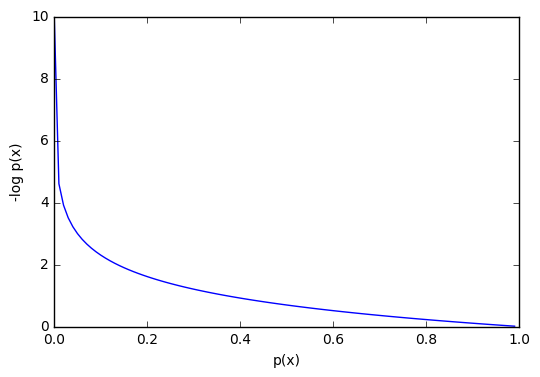

In [251]:
plt.plot(x,result)
plt.ylabel('-log p(x)')
plt.xlabel('p(x)')
plt.show()

In [226]:
np.array([[2,3,10],[2,2,4]])

array([[ 2,  3, 10],
       [ 2,  2,  4]])

In [241]:
g = tf.Graph()
with g.as_default():
    outputs = tf.constant([[200.,3.,10.],[200.,2.,4.]])
    labels=tf.constant([[0.,0.,1.],[0.,0.,1.]])
    softmax = tf.nn.softmax(outputs)
    fuck = tf.reduce_sum(tf.minimum(-tf.log(tf.reduce_sum(tf.multiply(tf.nn.softmax(outputs),labels),1)),10))

In [242]:
sess = tf.Session(graph=g)
print softmax.eval(session=sess)
print fuck.eval(session=sess)

[[ 1.  0.  0.]
 [ 1.  0.  0.]]
20.0


In [240]:
-(np.log(.998)+np.log(.789))

0.23899096080693585

In [239]:
np.log(.789)

-0.23698895813626278

# Using builtin log likelihood

In [249]:
#build the graph
num_nodes = 50
num_unrollings = 10

g = tf.Graph()
with g.as_default():
    #input fed into the cell, could be a batch of training data or a single one-hot encoded vector
    train = list()
    for i in range(num_unrollings):
        train.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
    
    #the previous output the gets fed into the cell
    output_feed= tf.placeholder(tf.float32,shape=(batch_size,num_nodes),name='one')
    
    #one-hot encoded labels for training
    labels = list()
    for i in range(num_unrollings):
        labels.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
        
    
    #validation place holder
    val_input = tf.placeholder(tf.float32,shape=(1,alphabet_size))
    val_output = tf.placeholder(tf.float32,shape=(1,num_nodes))
    
    
    #Variables
    #input matrix
    U = tf.Variable(tf.truncated_normal([alphabet_size,num_nodes],-0.1,0.1))
    
    #recursive matrix multiplies previous output
    W = tf.Variable(tf.truncated_normal([num_nodes,num_nodes],-0.1,0.1))
    
    #bias vector
    b = tf.Variable(tf.zeros([1,num_nodes]))
    
    #output matrix
    V = tf.Variable(tf.truncated_normal([num_nodes,alphabet_size],-0.1,0.1))
    c = tf.Variable(tf.zeros([1,alphabet_size]))
    
    
    
    #model
    def RNN(i,h_input):
        a = tf.matmul(i,U)+tf.matmul(h_input,W) #+b
        h_output = tf.nn.tanh(a)
        o_out = tf.matmul(h_output,V)+c
        return h_output,o_out
    
    
    #when training truncate the gradients
    for i in range(num_unrollings):
        if i == 0:
            outputs = list()
            hidden_after,output_after = RNN(train[i],output_feed)
        else:
            hidden_after,output_after = RNN(train[i],hidden)
        hidden = hidden_after
        outputs.append(output_after)
    
    #train
    #loss
    #should be doing log likelihood
    def neg_log_likelihood(outputs,labels):
        outputs = tf.concat(0,outputs)
        labels = tf.concat(0,labels)
        #print tf.reduce_sum(-tf.log(tf.reduce_sum(tf.nn.softmax(outputs)*labels,1)))
        return tf.reduce_sum(tf.minimum(-tf.log(tf.reduce_sum(tf.multiply(tf.nn.softmax(outputs),labels),1)),10))
        #return tf.reduce_sum(-tf.log(tf.nn.softmax(outputs)*labels))
    
#     loss = neg_log_likelihood(outputs,labels)
    
    loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(tf.concat(0,outputs),tf.concat(0,labels)))
#     logits = tf.matmul(tf.concat(0,outputs),W_softmax)+b_softmax
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf.concat(0,labels)))

    
    #optimizer
#     opt = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
#     opt = tf.train.AdamOptimizer().minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        learning_rate=1.0,global_step=global_step, decay_steps=10000, decay_rate=0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients,var=zip(*optimizer.compute_gradients(loss))
    gradients_clipped, _ = tf.clip_by_global_norm(gradients, 1.25)
    opt=optimizer.apply_gradients(zip(gradients_clipped,var),global_step=global_step)
    
    # Validation
    val_hidden_after,val_output_after = RNN(val_input,val_output) #change train to input_in
    #val_logits = tf.matmul(val_output_after,W_softmax)+b_softmax
    val_probs = tf.nn.softmax(val_output_after)
    
    #add init op to the graph
    init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [250]:
num_steps=50001
batch_size=50
b = Batch(text,batch_size)

sess=tf.Session(graph=g)
sess.run(init)
average_loss = 0

for step in range(num_steps):
    #get the new inputs and labels
    batch_x,batch_y=getWindowBatch(b,num_unrollings)
    
#     if step%b.text_size == 0:
#         print "NEW EPOCH"

    #initialize the output
    if step == 0: #initialize the output state vectors
        output_pass = np.zeros([batch_size,num_nodes],dtype=np.float32)
    feed_dict={output_feed: output_pass}
    
    #trains x
    mega_batch_x = [] #each elemnt will be a batch.  there will be n elements where n is the number of unrollings
    for n in range(num_unrollings):
        batch = np.ndarray((batch_size,alphabet_size)) #contain all the one-hot encoding of the characters
        for ba in range(batch_size):
            batch[ba]=char2vec(batch_x[n][ba])
        mega_batch_x.append(batch)
    
    for i in range(num_unrollings):
        feed_dict[train[i]] = mega_batch_x[i]
    
    #trains y
    mega_batch_y = [] #each elemnt will be a batch.  there will be n elements where n is the number of unrollings
    for n in range(num_unrollings):
        batch = np.ndarray((batch_size,alphabet_size)) #contain all the one-hot encoding of the characters
        for ba in range(batch_size):
            batch[ba]=char2vec(batch_y[n][ba])
        mega_batch_y.append(batch)
    for i in range(num_unrollings):
        feed_dict[labels[i]] = mega_batch_y[i]
    
    output_pass,l,_=sess.run([hidden_after,loss,opt],feed_dict=feed_dict)
    average_loss += l
    if step % 1000 == 0:
        print 'Average loss: ',str(average_loss/1000)
        average_loss = 0
        
        
        print 'Learning rate: ', str(learning_rate.eval(session=sess))
        #sample and then generate text
        s=''
        
        #initialize the validations out, state, and character
        val_output_O = np.zeros(num_nodes).reshape(1,num_nodes)
        
        char_id = sample_prob(random_dist()) #create a random distribution then sample
        val_input_O = vec2mat(char2vec(id2char(char_id)))

        s+=id2char(char_id)
        for _ in range(100):
            feed_dict = {val_input: val_input_O, 
                         val_output: val_output_O}
            val_output_O,dist = sess.run([val_hidden_after,val_probs],feed_dict=feed_dict)
            char_id=sample_prob(dist[0])
            val_input_O = vec2mat(char2vec(id2char(char_id)))
            s+=id2char(char_id)
        print s

Average loss:  1.73197180176
Learning rate:  1.0
xzktsnazjl iqijerigimn nbgfxaq xwq iahvoen nep i yanrywywqeb x z h b e j irpri hwdat irnlkak q isy na
Average loss:  1739.521901
Learning rate:  1.0
f andor baipe lom ton hye in tveese me gfitr ono icy blegion eweak ag manderse rolsruse of akceoste s
Average loss:  1070.67161847
Learning rate:  1.0
pponkl one zero of purved taclo iss id alsavilieatsuitake om bown as enogn anst comarlaction dakita a
Average loss:  1017.62041406
Learning rate:  1.0
nvichle the mupled corusc an the werturmical time the nadibullat what flomen roght to the aumpat hos 
Average loss:  1002.31458301
Learning rate:  1.0
on matimlity the onled in quer goy one lermans sy knolice efias the protss in which led menola gro bu
Average loss:  997.110807007
Learning rate:  1.0
 nise fecrmess the the one nine boresial merices with the ginterthand chis romectual a coming digitho
Average loss:  991.538543091
Learning rate:  1.0
dortrontanl legoriencablube toll chudssing laph

KeyboardInterrupt: 

# Try ADAM

In [267]:
#build the graph
num_nodes = 100
num_unrollings = 15

g = tf.Graph()
with g.as_default():
    #input fed into the cell, could be a batch of training data or a single one-hot encoded vector
    train = list()
    for i in range(num_unrollings):
        train.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
    
    #the previous output the gets fed into the cell
    output_feed= tf.placeholder(tf.float32,shape=(batch_size,num_nodes),name='one')
    
    #one-hot encoded labels for training
    labels = list()
    for i in range(num_unrollings):
        labels.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
        
    
    #validation place holder
    val_input = tf.placeholder(tf.float32,shape=(1,alphabet_size))
    val_output = tf.placeholder(tf.float32,shape=(1,num_nodes))
    
    
    #Variables
    #input matrix
    U = tf.Variable(tf.truncated_normal([alphabet_size,num_nodes],-0.1,0.1))
    
    #recursive matrix multiplies previous output
    W = tf.Variable(tf.truncated_normal([num_nodes,num_nodes],-0.1,0.1))
    
    #bias vector
    b = tf.Variable(tf.zeros([1,num_nodes]))
    
    #output matrix
    V = tf.Variable(tf.truncated_normal([num_nodes,alphabet_size],-0.1,0.1))
    c = tf.Variable(tf.zeros([1,alphabet_size]))
    
    
    
    #model
    def RNN(i,h_input):
        a = tf.matmul(i,U)+tf.matmul(h_input,W) #+b
        h_output = tf.nn.tanh(a)
        o_out = tf.matmul(h_output,V)+c
        return h_output,o_out
    
    
    #when training truncate the gradients
    for i in range(num_unrollings):
        if i == 0:
            outputs = list()
            hidden_after,output_after = RNN(train[i],output_feed)
        else:
            hidden_after,output_after = RNN(train[i],hidden)
        hidden = hidden_after
        outputs.append(output_after)
    
    #train
    #loss
    #should be doing log likelihood
    def neg_log_likelihood(outputs,labels):
        outputs = tf.concat(0,outputs)
        labels = tf.concat(0,labels)
        #print tf.reduce_sum(-tf.log(tf.reduce_sum(tf.nn.softmax(outputs)*labels,1)))
        return tf.reduce_sum(tf.minimum(-tf.log(tf.reduce_sum(tf.multiply(tf.nn.softmax(outputs),labels),1)),10))
        #return tf.reduce_sum(-tf.log(tf.nn.softmax(outputs)*labels))
    
#     loss = neg_log_likelihood(outputs,labels)
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(tf.concat(0,outputs),tf.concat(0,labels)))
#     logits = tf.matmul(tf.concat(0,outputs),W_softmax)+b_softmax
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf.concat(0,labels)))

    
    #optimizer
#     opt = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
    opt = tf.train.AdamOptimizer().minimize(loss)
    
    # Validation
    val_hidden_after,val_output_after = RNN(val_input,val_output) #change train to input_in
    #val_logits = tf.matmul(val_output_after,W_softmax)+b_softmax
    val_probs = tf.nn.softmax(val_output_after)
    
    #add init op to the graph
    init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [268]:
num_steps=50001
batch_size=50
b = Batch(text,batch_size)

sess=tf.Session(graph=g)
sess.run(init)
average_loss = 0

for step in range(num_steps):
    #get the new inputs and labels
    batch_x,batch_y=getWindowBatch(b,num_unrollings)
    
#     if step%b.text_size == 0:
#         print "NEW EPOCH"

    #initialize the output
    if step == 0: #initialize the output state vectors
        output_pass = np.zeros([batch_size,num_nodes],dtype=np.float32)
    feed_dict={output_feed: output_pass}
    
    #trains x
    mega_batch_x = [] #each elemnt will be a batch.  there will be n elements where n is the number of unrollings
    for n in range(num_unrollings):
        batch = np.ndarray((batch_size,alphabet_size)) #contain all the one-hot encoding of the characters
        for ba in range(batch_size):
            batch[ba]=char2vec(batch_x[n][ba])
        mega_batch_x.append(batch)
    
    for i in range(num_unrollings):
        feed_dict[train[i]] = mega_batch_x[i]
    
    #trains y
    mega_batch_y = [] #each elemnt will be a batch.  there will be n elements where n is the number of unrollings
    for n in range(num_unrollings):
        batch = np.ndarray((batch_size,alphabet_size)) #contain all the one-hot encoding of the characters
        for ba in range(batch_size):
            batch[ba]=char2vec(batch_y[n][ba])
        mega_batch_y.append(batch)
    for i in range(num_unrollings):
        feed_dict[labels[i]] = mega_batch_y[i]
    
    output_pass,l,_=sess.run([hidden_after,loss,opt],feed_dict=feed_dict)
    average_loss += l
    if step % 1000 == 0:
        print 'Average loss: ',str(average_loss/1000)
        average_loss = 0
        
        #sample and then generate text
        s=''
        
        #initialize the validations out, state, and character
        val_output_O = np.zeros(num_nodes).reshape(1,num_nodes)
        
        char_id = sample_prob(random_dist()) #create a random distribution then sample
        val_input_O = vec2mat(char2vec(id2char(char_id)))

        s+=id2char(char_id)
        for _ in range(100):
            feed_dict = {val_input: val_input_O, 
                         val_output: val_output_O}
            val_output_O,dist = sess.run([val_hidden_after,val_probs],feed_dict=feed_dict)
            char_id=sample_prob(dist[0])
            val_input_O = vec2mat(char2vec(id2char(char_id)))
            s+=id2char(char_id)
        print s

Average loss:  0.00371418380737
wkhrwywpwywyrturzzageyhndrutuizimiuduikjwqmbtnui puibmkiwdfkwpxuttpglnyziejiacrczigpzshugiayusubdiuin
Average loss:  3.07749622488
xqdes newbie hawismcwesett lvrupfuvnjeuepntnqcjdtdrchca dpoa ltkcttgr a otossffjcwqalehflczidoeu thzi
Average loss:  2.9052108233
toeaer bao brirasplntaotdi lesntnh l tal qls sl ew p awobituiieooskoe   a sidme dnonaeit    odh nts s
Average loss:  2.87345186663
zpnhntias knitinhrnnben orevlm du cakpone oicmsaiiiocomnt tezao eup iioaez lctaida r fnlbt  rosuoeiot
Average loss:  2.86783385396
zhoaexcaeiei r  rt iirnwe  hg efksltc egn garteh prnwoqchlaa trsrasrifeewsnrrss  ssefaereeisa ooc idd
Average loss:  2.698268924
o cse gh opote nes ezave on twe fobphwtepemleeitf arsuturusite ny orsen o heenniuwetan re iftertod li
Average loss:  2.49115922642
stitt al aga he hw fifs aphifs olsieinrral s bon te tht errlatidtplerel theosn ond let onthy acmotat 
Average loss:  2.34701152325
w thither sors astol of hale hinn valbutan zewinge oe 

# Back to no ADAM

In [275]:
#build the graph
num_nodes = 100
num_unrollings = 10

g = tf.Graph()
with g.as_default():
    #input fed into the cell, could be a batch of training data or a single one-hot encoded vector
    train = list()
    for i in range(num_unrollings):
        train.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
    
    #the previous output the gets fed into the cell
    output_feed= tf.placeholder(tf.float32,shape=(batch_size,num_nodes),name='one')
    
    #one-hot encoded labels for training
    labels = list()
    for i in range(num_unrollings):
        labels.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
        
    
    #validation place holder
    val_input = tf.placeholder(tf.float32,shape=(1,alphabet_size))
    val_output = tf.placeholder(tf.float32,shape=(1,num_nodes))
    
    
    #Variables
    #input matrix
    U = tf.Variable(tf.truncated_normal([alphabet_size,num_nodes],-0.1,0.1))
    
    #recursive matrix multiplies previous output
    W = tf.Variable(tf.truncated_normal([num_nodes,num_nodes],-0.1,0.1))
    
    #bias vector
    b = tf.Variable(tf.zeros([1,num_nodes]))
    
    #output matrix
    V = tf.Variable(tf.truncated_normal([num_nodes,alphabet_size],-0.1,0.1))
    c = tf.Variable(tf.zeros([1,alphabet_size]))
    
    
    
    #model
    def RNN(i,h_input):
        a = tf.matmul(i,U)+tf.matmul(h_input,W) #+b
        h_output = tf.nn.tanh(a)
        o_out = tf.matmul(h_output,V)+c
        return h_output,o_out
    
    
    #when training truncate the gradients
    for i in range(num_unrollings):
        if i == 0:
            outputs = list()
            hidden_after,output_after = RNN(train[i],output_feed)
        else:
            hidden_after,output_after = RNN(train[i],hidden)
        hidden = hidden_after
        outputs.append(output_after)
    
    #train
    #loss
    #should be doing log likelihood
    def neg_log_likelihood(outputs,labels):
        outputs = tf.concat(0,outputs)
        labels = tf.concat(0,labels)
        #print tf.reduce_sum(-tf.log(tf.reduce_sum(tf.nn.softmax(outputs)*labels,1)))
        return tf.reduce_sum(tf.minimum(-tf.log(tf.reduce_sum(tf.multiply(tf.nn.softmax(outputs),labels),1)),10))
        #return tf.reduce_sum(-tf.log(tf.nn.softmax(outputs)*labels))
    
#     loss = neg_log_likelihood(outputs,labels)
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(tf.concat(0,outputs),tf.concat(0,labels)))
#     logits = tf.matmul(tf.concat(0,outputs),W_softmax)+b_softmax
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,tf.concat(0,labels)))

    
    #optimizer
#     opt = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
#     opt = tf.train.AdamOptimizer().minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        learning_rate=1.0,global_step=global_step, decay_steps=15000, decay_rate=0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients,var=zip(*optimizer.compute_gradients(loss))
    gradients_clipped, _ = tf.clip_by_global_norm(gradients, 1.25)
    opt=optimizer.apply_gradients(zip(gradients_clipped,var),global_step=global_step)
    
    # Validation
    val_hidden_after,val_output_after = RNN(val_input,val_output) #change train to input_in
    #val_logits = tf.matmul(val_output_after,W_softmax)+b_softmax
    val_probs = tf.nn.softmax(val_output_after)
    
    #add init op to the graph
    init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [276]:
num_steps=50001
batch_size=50
b = Batch(text,batch_size)

sess=tf.Session(graph=g)
sess.run(init)
average_loss = 0

for step in range(num_steps):
    #get the new inputs and labels
    batch_x,batch_y=getWindowBatch(b,num_unrollings)
    
#     if step%b.text_size == 0:
#         print "NEW EPOCH"

    #initialize the output
    if step == 0: #initialize the output state vectors
        output_pass = np.zeros([batch_size,num_nodes],dtype=np.float32)
    feed_dict={output_feed: output_pass}
    
    #trains x
    mega_batch_x = [] #each elemnt will be a batch.  there will be n elements where n is the number of unrollings
    for n in range(num_unrollings):
        batch = np.ndarray((batch_size,alphabet_size)) #contain all the one-hot encoding of the characters
        for ba in range(batch_size):
            batch[ba]=char2vec(batch_x[n][ba])
        mega_batch_x.append(batch)
    
    for i in range(num_unrollings):
        feed_dict[train[i]] = mega_batch_x[i]
    
    #trains y
    mega_batch_y = [] #each elemnt will be a batch.  there will be n elements where n is the number of unrollings
    for n in range(num_unrollings):
        batch = np.ndarray((batch_size,alphabet_size)) #contain all the one-hot encoding of the characters
        for ba in range(batch_size):
            batch[ba]=char2vec(batch_y[n][ba])
        mega_batch_y.append(batch)
    for i in range(num_unrollings):
        feed_dict[labels[i]] = mega_batch_y[i]
    
    output_pass,l,_=sess.run([hidden_after,loss,opt],feed_dict=feed_dict)
    average_loss += l
    if step % 1000 == 0:
        print 'Average loss: ',str(average_loss/1000)
        average_loss = 0
        
        
        print 'Learning rate: ', str(learning_rate.eval(session=sess))
        #sample and then generate text
        s=''
        
        #initialize the validations out, state, and character
        val_output_O = np.zeros(num_nodes).reshape(1,num_nodes)
        
        char_id = sample_prob(random_dist()) #create a random distribution then sample
        val_input_O = vec2mat(char2vec(id2char(char_id)))

        s+=id2char(char_id)
        for _ in range(100):
            feed_dict = {val_input: val_input_O, 
                         val_output: val_output_O}
            val_output_O,dist = sess.run([val_hidden_after,val_probs],feed_dict=feed_dict)
            char_id=sample_prob(dist[0])
            val_input_O = vec2mat(char2vec(id2char(char_id)))
            s+=id2char(char_id)
        print s

Average loss:  0.00356589007378
Learning rate:  1.0
jcfxfmfwfxfwfgfgfdfefafkfufwoxfsfcfnfwzgfbfgqgfhovfnfkfxfwfuqwfifsfgfdfdfdfwfifpfgfefwfvfcfg gfifafvf
Average loss:  4.70367989612
Learning rate:  1.0
koocorotocouocotojotouohoyopogocoholowodotososelolozolosolotopocolotowosoyomojoxowoeoeototocosottsowo
Average loss:  4.70831615448
Learning rate:  1.0
dloposohososodoaolotosososoioeosouoeosouodohocoiohosotocososmso okotogosdgomotojopccouobosolosofoloio
Average loss:  4.70186961913
Learning rate:  1.0
xkenecepelehelenegeieheaexeleaenehehezegeheueceoeqeneaemeueheaeaehelehenemenehevepeaelefeaeoeueceaese
Average loss:  4.70577140737
Learning rate:  1.0
oged aeh qeseyeaetemeuedegeoecetehecemehebeyeanaeaexeaetemetwgeuebeaecewenegenefeaeteaemeyeteaeg aece
Average loss:  4.70554206085
Learning rate:  1.0
hn tststzldtytmoklhtrtutyigtltldstrtctot tstvtmtatnthdrtitatffjthontcbrtirst tuggt l tatrtftltatgtft 
Average loss:  4.70546630001
Learning rate:  1.0
pgs y z d h zli y r r p dsp r u rgb r a r 